In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sns.set()

Wczytuję dane i wykonuję modyfikację, takie jak podczas tworzenia regresji, aby uniknąć rozbierzności w danych.

In [23]:
df_waw_text = pd.read_excel(r'E:\python\projects\apartments\data\data_text.xlsx')

df_waw_text.drop_duplicates(inplace=True)
def drop_value(df, column, value): # funkcja do usuwania wybranych wartości
    index = df[df[column] == value].index
    df.drop(index=index, inplace=True)
    df.reset_index(drop=True, inplace=True)

drop_value(df_waw_text, 'zabudowa', 'Loft')
drop_value(df_waw_text, 'zabudowa', 'Pozostałe')

drop_value(df_waw_text, 'poziom', 'Suterena')
drop_value(df_waw_text, 'poziom', 'Poddasze')

drop_value(df_waw_text, 'poziom', 'Tak')
drop_value(df_waw_text, 'poziom', 'Nie')

dzielnica = pd.get_dummies(data=df_waw_text['dzielnica'])
od = pd.get_dummies(data=df_waw_text['od'])
poziom = pd.get_dummies(data=df_waw_text['poziom'])
zabudowa = pd.get_dummies(data=df_waw_text['zabudowa'])

df_waw_regression = pd.concat([df_waw_text, dzielnica, od, poziom, zabudowa], axis=1)

y = df_waw_regression['cena całkowita']
X = df_waw_regression.drop(['cena całkowita', 'dzielnica', 'od', 'poziom', 'zabudowa',
                 'Mokotów', 'Osoby prywatnej', 'Powyżej 10', 'Apartamentowiec', 'tytuł', 'opis'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60)

In [24]:
lm = pickle.load(open(r'E:\python\projects\apartments\pickle\linear_model.pickle', 'rb'))
lm.fit(X, y)
prediction = lm.predict(X) 

<AxesSubplot:ylabel='cena całkowita'>

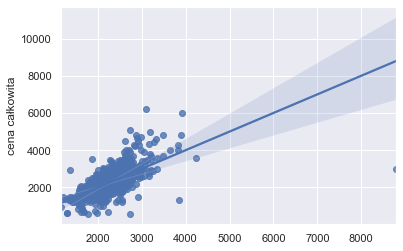

In [25]:
sns.regplot(x=prediction, y=y)

Model bez uwzględniania opisów radzi sobie całkiem dobrze, jednak pojawiają się punkty które znacząco odbiegają od predykcji. Być może metody pzetwarzania języka naturalnego będą potrafiły znaleźć pewne zależności i porpawić predyjkcję

In [26]:
df_waw_text['predykcja'] = lm.predict(X)
df_waw_text['predykcja'] = round(df_waw_text['predykcja'],2)

df_waw_text[df_waw_text['predykcja'] == df_waw_text['predykcja'].max()]

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja
5,Wola,Biuro / Deweloper,1,Blok,400,2 pokoje z miejscem postojowym w Centrum przy ...,Na wynajem mieszkanie 2 pokoje w stanie idealn...,3000,8793.63


In [27]:
print(df_waw_text['opis'][df_waw_text['predykcja'] == df_waw_text['predykcja'].max()].to_markdown())

|    | opis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|---:|:------------------------------------------------------------------------------------------------------------------------

Jedna z predykcji jest wyjątkowo odległa od prawdy. Jest to jednak spowodowane błędem w ogłoszeniu. Z opisu wynika, że mieszkanie ma 40 metrów kwadratowych, natomiast w tabelce jest podane 400. 

<AxesSubplot:ylabel='cena całkowita'>

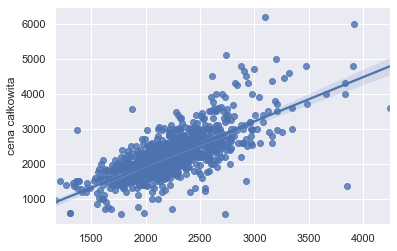

In [28]:
sns.regplot(x=np.delete(prediction, 5), y=y.drop(5))

Wykres regresji bez tej wartości wygląda znacznie lepiej. Jednak wciąż pojawiają się punkty które znacząco odbiegają od predykcji. Być może metody pzetwarzania języka naturalnego będą potrafiły znaleźć pewne zależności i porpawić predyjkcję. Usunę ją recznie, aby nie zaburzało mi to następnych wykresów.

In [29]:
drop_value(df_waw_text, 'predykcja', df_waw_text['predykcja'].max())

### EDA (Exploratory data analysis) pod kątem NLP

Tworzę kolumnę składniki resztowe oraz kolumnę ze znormalizowanymi składnikami resztowymi.

In [30]:
df_waw_text['składniki resztowe'] = df_waw_text['cena całkowita'] - df_waw_text['predykcja']
df_waw_text['składniki resztowe norm'] = (df_waw_text['predykcja'] - df_waw_text['cena całkowita'])/ df_waw_text['predykcja']
df_waw_text.head()

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja,składniki resztowe,składniki resztowe norm
0,Białołęka,Osoby prywatnej,1,Blok,46,Mieszkanie 49 m2 1300 zł + czynsz. Od zaraz,Do wynajęcia mieszkanie 49m2 na Białołęce przy...,1800,2101.59,-301.59,0.143506
1,Ursynów,Osoby prywatnej,3,Blok,64,Wynajmę 3-pokojowe mieszkanie na Kabatach przy...,Wynajmę na co najmniej rok 3-pokojowe umeblowa...,3000,2591.80,408.20,-0.157497
2,Mokotów,Osoby prywatnej,8,Blok,85,Mieszkanie do wynajęcia Służew Bezpośrednio,Wynajmę bezpośrednio duże przestronne 85m2 mie...,2901,3135.60,-234.60,0.074818
3,Ursynów,Osoby prywatnej,3,Blok,45,Wynajem mieszkanie Warszawa na Ursynowie,Witam \nWynajmę śliczne mieszkanie na Ursynowi...,2800,2235.95,564.05,-0.252264
4,Białołęka,Osoby prywatnej,Parter,Blok,29,Funkcjonalna kawalerka z miejscem parkingowym ...,Nowa kawalerka z miejscem parkingowym w cenie ...,1750,1706.18,43.82,-0.025683


In [31]:
df_waw_group = df_waw_text.groupby('dzielnica')

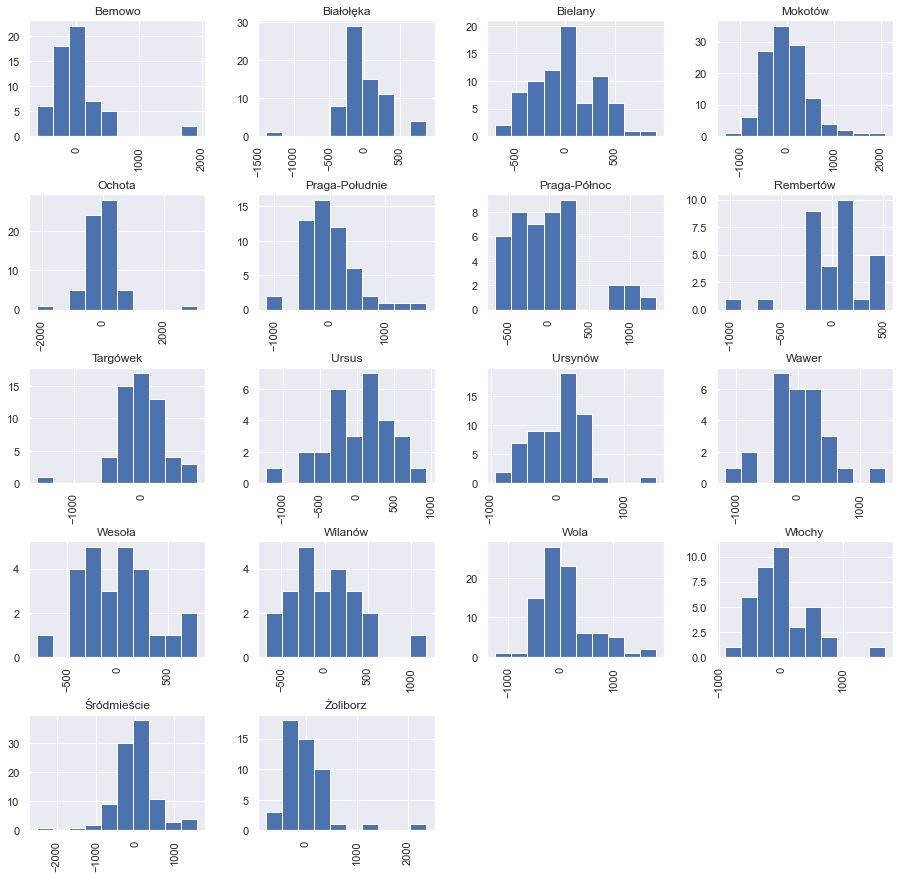

In [32]:
df_waw_text.hist(column='składniki resztowe', by='dzielnica', figsize=(15,15))
plt.show()

In [33]:
print(df_waw_text.median())
df_waw_group.median()

powierzchnia                 40.000000
cena całkowita             2195.000000
predykcja                  2195.240000
składniki resztowe          -19.540000
składniki resztowe norm       0.007853
dtype: float64


,powierzchnia,cena całkowita,predykcja,składniki resztowe,składniki resztowe norm
dzielnica,,,,,
Bemowo,45.5,2178.5,2247.835,-60.115,0.028751
Białołęka,46.0,2001.0,2095.015,-67.535,0.035105
Bielany,40.0,2101.0,2132.290,4.560,-0.002540
Mokotów,40.0,2200.0,2231.595,-42.535,0.021387
Ochota,37.0,2101.0,2134.045,-13.470,0.005456
Praga-Południe,47.5,2300.5,2309.120,-46.820,0.019585
Praga-Północ,44.0,2301.0,2307.460,-14.160,0.007027
Rembertów,38.0,1801.0,1778.140,70.060,-0.040475
Targówek,41.0,2001.0,2024.430,13.110,-0.005995


Mediana składników resztowych pokazuje, czy w danej dzielnicy większość cen jes zawyżonych (reszty dodatnie), czy zaniżonych (reszty ujemne).  *mediana dla Bemowa = -60.115, czyli 50% wszystkich predykcji jest niższa od ceny faktycznej o 60,12 zł*. Potwierdzenie togo widzać na wykresie powyżej.  
Z danych wynika, że model zawyża najbardziej ceny na Ursusie, Rembertowie i Ursynowie. Zaniża zaś na Żoliborzu, Bemowie i Białołęce. Najtrafniej ocenia mieszkania z Wawra, Wesołej, Śródmieścia i Bielan.  
Średnio dla całej Warszawy, większość predykcji jest nieznacznie zaniżona.

In [34]:
df_waw_group_abs = df_waw_group['składniki resztowe'].apply(abs)
df_waw_group_abs = pd.concat([df_waw_text.drop(['składniki resztowe'], axis=1), df_waw_group_abs], axis=1)

In [35]:
df_waw_group_abs.describe()

,powierzchnia,cena całkowita,predykcja,składniki resztowe norm,składniki resztowe
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,42.828882,2235.282888,2229.552295,0.004279,323.032532
std,15.855580,655.671979,377.197229,0.196228,328.482567
min,2.000000,551.000000,1170.830000,-1.155305,1.320000
25%,32.000000,1801.000000,1999.780000,-0.093357,112.305000
50%,40.000000,2195.000000,2195.240000,0.007853,238.520000
75%,50.000000,2550.000000,2428.700000,0.118537,411.015000
max,160.000000,6200.000000,4248.120000,0.789321,3105.310000


W tabeli powyżej przekształciłem kolumnę składnik resztowe w wartości absolutne (bez minusów). Dzięki temu mogę wyciągnąć średnią, która wynosi ok. 323,03. Model średnio mysli się taką wartość (bez uzględnienia w którą stronę). 

In [36]:
df_waw_text['tytuł długość'] = df_waw_text['tytuł'].str.split().apply(len)
df_waw_text['opis długość'] = df_waw_text['opis'].str.split().apply(len)

Liczę ilość słów w kolumnach tytuł i opis

In [37]:
df_waw_text.head()

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja,składniki resztowe,składniki resztowe norm,tytuł długość,opis długość
0,Białołęka,Osoby prywatnej,1,Blok,46,Mieszkanie 49 m2 1300 zł + czynsz. Od zaraz,Do wynajęcia mieszkanie 49m2 na Białołęce przy...,1800,2101.59,-301.59,0.143506,9,35
1,Ursynów,Osoby prywatnej,3,Blok,64,Wynajmę 3-pokojowe mieszkanie na Kabatach przy...,Wynajmę na co najmniej rok 3-pokojowe umeblowa...,3000,2591.80,408.20,-0.157497,7,228
2,Mokotów,Osoby prywatnej,8,Blok,85,Mieszkanie do wynajęcia Służew Bezpośrednio,Wynajmę bezpośrednio duże przestronne 85m2 mie...,2901,3135.60,-234.60,0.074818,5,66
3,Ursynów,Osoby prywatnej,3,Blok,45,Wynajem mieszkanie Warszawa na Ursynowie,Witam \nWynajmę śliczne mieszkanie na Ursynowi...,2800,2235.95,564.05,-0.252264,5,79
4,Białołęka,Osoby prywatnej,Parter,Blok,29,Funkcjonalna kawalerka z miejscem parkingowym ...,Nowa kawalerka z miejscem parkingowym w cenie ...,1750,1706.18,43.82,-0.025683,7,79


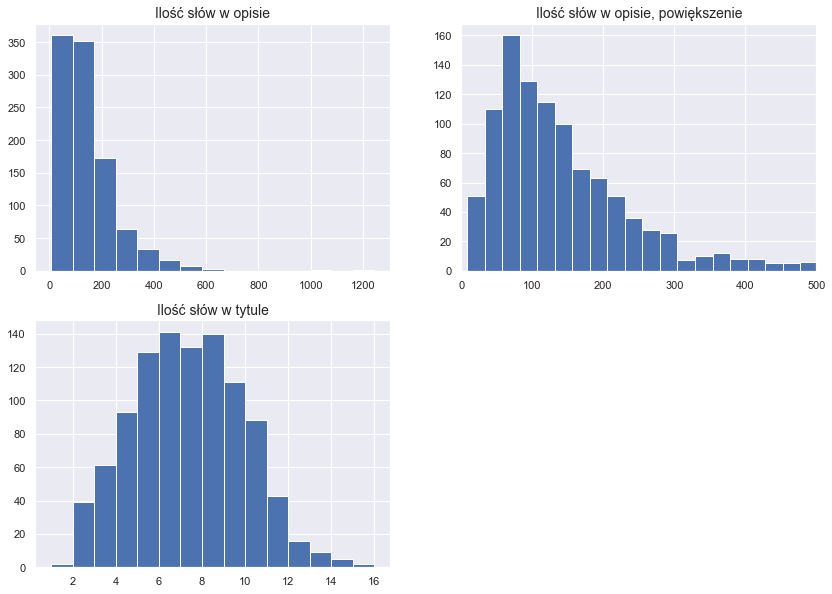

In [38]:
plt.figure(figsize=(14,10))

plt.subplot(2, 2, 3)
plt.hist(df_waw_text['tytuł długość'], bins=15)
plt.title('Ilość słów w tytule', fontdict={'fontsize':14})

plt.subplot(2, 2, 1)
plt.hist(df_waw_text['opis długość'], bins=15)
plt.title('Ilość słów w opisie', fontdict={'fontsize':14})

plt.subplot(2, 2, 2)
plt.hist(df_waw_text['opis długość'], bins=50)
plt.title('Ilość słów w opisie, powiększenie', fontdict={'fontsize':14})
plt.xlim(0, 500)
plt.show()

Większość opisów ogłoszeń liczy od 25 do 125 słów. Istnieje pare bardzo długich (ponad 600 słów). Większość tytułów posiada od 4 do 11 słów. Nie występują watrości zacząco odbiegające od średniej

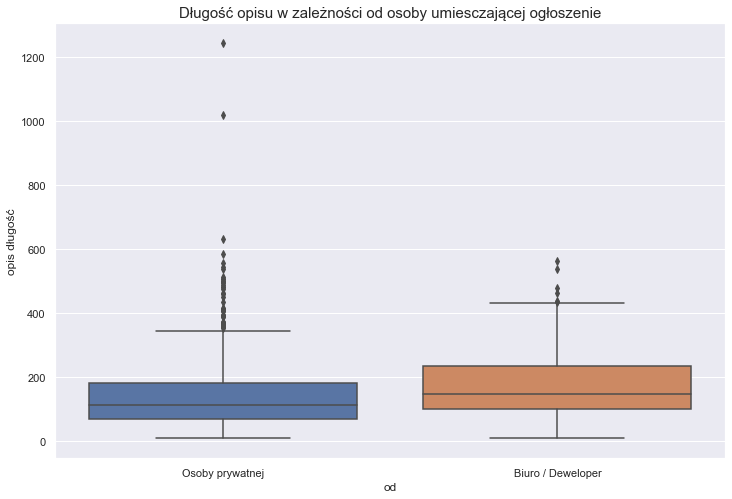

In [39]:
plt.figure(figsize=(12,8))
sns.boxplot(x=df_waw_text['od'], y=df_waw_text['opis długość'])
plt.title('Długość opisu w zależności od osoby umiesczającej ogłoszenie', fontdict={'fontsize':15})
plt.show()

Ogłoszenia od osób prywatnych są zazwyczaj krótsze, jednak często pojawiają się ogłoszenia o wiele dłuższe. Ogłoszenia od deweloperów są bardziej usystematyzowane. 

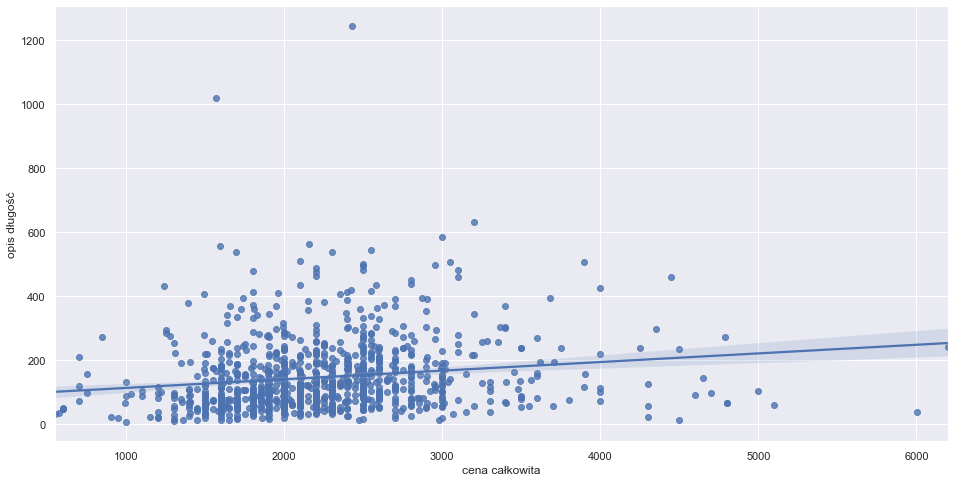

In [40]:
plt.figure(figsize=(16,8))
sns.regplot(x=df_waw_text['cena całkowita'], y=df_waw_text['opis długość'])
plt.show()

Liniowa zależność między długością opisu a ceną mieszkania nie występuje.

Zapiszę posiadaną tabelę za pomocą pickle

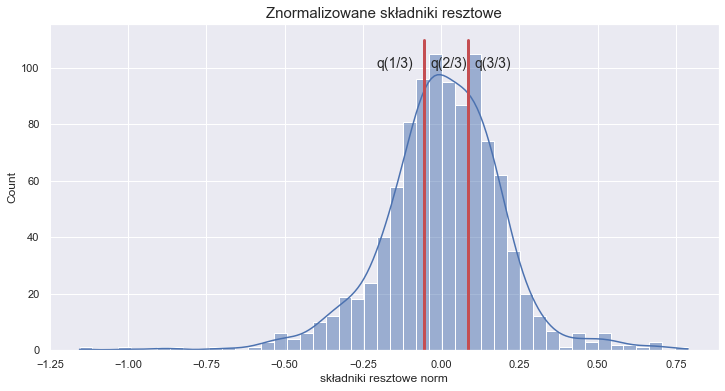

In [42]:
q1 = df_waw_text['składniki resztowe norm'].quantile(q=1/3)
q2 = df_waw_text['składniki resztowe norm'].quantile(q=2/3)

plt.figure(figsize=(12,6))
sns.histplot(df_waw_text['składniki resztowe norm'], kde = True)
plt.title('Znormalizowane składniki resztowe', fontdict={'fontsize':15})

plt.plot([q1,q1], [0,110], color='r', lw=3)
plt.plot([q2,q2], [0,110], color='r', lw=3)
plt.text(q1-0.15, 100, 'q(1/3)', fontdict={'fontsize':14})
plt.text(q1+0.02, 100, 'q(2/3)', fontdict={'fontsize':14})
plt.text(q2+0.02, 100, 'q(3/3)', fontdict={'fontsize':14})

plt.show()

Znormalizowane składniki resztowe będą dla mnie stanowiły grupy odniesienia w dalszej części. *q(1/3)* jest grupą niedowardościowaną (jedna trzecia wszystkich obserwacji). *q(2/3)* jest grupą trafnie oceniną (jedna trzecia wszystkich obserwacji), a *q(3/3)* jest grupą przecenioną (jedna trzecia wszystkich obserwacji). Na podstawie opisów i predykcji spróbuję przypisać właściwe etykiety do ogłoszeń.

In [78]:
df_waw_text.to_pickle(r'E:\python\projects\apartments\pickle\df_waw_text.pickle')

## Przetwarzanie tekstu

In [32]:
import re
import pandas as pd
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
df_waw_text = pd.read_pickle(r'E:\python\projects\apartments\pickle\df_waw_text.pickle')

### Czyszczenie tekstu

In [178]:
text = 'wb 30m2'
text = re.sub(r' \d+\s*\w2' , '', text)
text

'wb'

In [190]:
def clean_data(text):
    text = text.lower() # małe litery
    text = re.sub(r'\W', ' ', text) # usunięcie znaków np. nawiasy
    text = re.sub('\n', ' ', text) # usuniecie nowych linii
    text = re.sub(r'\d\d\d\W* pokaż numer telefonu', '', text) # usunięcie ukrytych telefonów
    text = re.sub(r'\d+\s*\d+\s* zł| \d+\s*\d+\s* pln| \d+\s*\d+\s* zl', '', text) # usunięcie cen
    try:
        text_new = re.findall(r'\d\s* po\w+', text)[0].replace(' ','') # łączy liczbę z pokojem
        text = re.sub(r'\d\s* pok\w+', text_new, text)
    except Exception:
        pass
    text = re.sub(r' \d+\s*\w2' , '', text) # usuwa m2
    return text
    #text = re.sub('\w*\d\w*', '', text)

In [191]:
description = df_waw_text['opis'].apply(clean_data)
title = df_waw_text['tytuł'].apply(clean_data)
data_clean = pd.concat([df_waw_text[['cena całkowita', 'składniki resztowe norm']], description, title,], axis=1)
data_clean.head()

,cena całkowita,składniki resztowe norm,opis,tytuł
0,1800,0.143506,do wynajęcia mieszkanie na białołęce przy ul ...,mieszkanie 49 m czynsz od zaraz
1,3000,-0.157497,wynajmę na co najmniej rok 3pokojowe umeblowan...,wynajmę 3pokojowe mieszkanie na kabatach przy ...
2,2901,0.074818,wynajmę bezpośrednio duże przestronne mieszkan...,mieszkanie do wynajęcia służew bezpośrednio
3,2800,-0.252264,witam wynajmę śliczne mieszkanie na ursynowie...,wynajem mieszkanie warszawa na ursynowie
4,1750,-0.025683,nowa kawalerka z miejscem parkingowym w cenie ...,funkcjonalna kawalerka z miejscem parkingowym ...


In [192]:
q1 = df_waw_text['składniki resztowe norm'].quantile(q=1/3)
q2 = df_waw_text['składniki resztowe norm'].quantile(q=2/3)

df_waw_text_sort = data_clean.sort_values('składniki resztowe norm')
df_waw_text_underpriced = df_waw_text_sort[df_waw_text_sort['składniki resztowe norm'] < q1]
df_waw_text_normal = df_waw_text_sort[(df_waw_text_sort['składniki resztowe norm'] < q2) &
                                      (df_waw_text_sort['składniki resztowe norm'] > q1)]
df_waw_text_overpriced = df_waw_text_sort[df_waw_text_sort['składniki resztowe norm'] > q2]

print(len(df_waw_text))
print(len(df_waw_text_underpriced))
print(len(df_waw_text_normal ))
print(len(df_waw_text_overpriced))

df_waw_text_sort.loc[df_waw_text_overpriced.index, 'etykieta'] = 'przeszacowane'
df_waw_text_sort.loc[df_waw_text_normal.index, 'etykieta'] = 'dobrze'
df_waw_text_sort.loc[df_waw_text_underpriced.index, 'etykieta'] = 'niedoszacowane'

df_waw_text_sort.to_pickle(r'E:\python\projects\apartments\pickle\df_waw_text_sort.pickle')

1011
337
337
337


Stworzyłem tabelę *df_waw_text_sort* zawierającą etykiety, które z ogłoszeń zostały przeszacowane, niedoszacowane i ocenione dobrze. Zapisałem ją za pomocą pickle.

### Wektoryzacja słów

In [217]:
df_waw_text_sort = pd.read_pickle(r'E:\python\projects\apartments\pickle\df_waw_text_sort.pickle')

In [218]:
pol_stop_words = '''
    ach aj albo bardzo bez bo być ci cię ciebie co czy daleko dla dlaczego dlatego do dobrze dokąd dość dużo dwa dwaj
    dwie dwoje dziś dzisiaj gdyby gdzie go ich ile im inny ja ją jak jakby jaki je jeden jedna jedno jego jej jemu jeśli
    jest jestem jeżeli już każdy kiedy kierunku kto ku lub ma mają mam mi mną mnie moi mój moja moje może mu my na nam 
    nami nas nasi nasz nasza nasze natychmiast nią nic nich nie niego niej niemu nigdy nim nimi niż obok od około on
    ona one oni ono owszem po pod ponieważ przed przedtem są sam sama się skąd tak taki tam ten to tobą tobie tu
    tutaj twoi twój twoja twoje ty wam wami was wasi wasz wasza wasze we więc wszystko wtedy wy żaden zawsze że
    mieszkanie mieszkania oraz przy ul za ok czynsz kaucja opłaty zł wynajmę wynajęcia
    '''.split()

count_vectorizer_description = CountVectorizer(stop_words=pol_stop_words, lowercase=False)
document_term_matrix_description = count_vectorizer_description.fit_transform(df_waw_text_sort['opis'])

count_vectorizer_title = CountVectorizer(stop_words=pol_stop_words, lowercase=False)
document_term_matrix_title = count_vectorizer_title.fit_transform(df_waw_text_sort['tytuł'])

In [219]:
with open(r'E:\python\projects\apartments\pickle\document_term_matrix_description.pickle', 'wb') as writer:
    pickle.dump(document_term_matrix_description, writer)
    
with open(r'E:\python\projects\apartments\pickle\document_term_matrix_title.pickle', 'wb') as writer:
    pickle.dump(document_term_matrix_title, writer)

Tworze df_document_term_matrix, zawierający występowania poszczególnych słow w zależności od etykiety.

In [220]:
df_document_term_matrix_description = pd.DataFrame(document_term_matrix_description.toarray(),
                                       columns=count_vectorizer_description.get_feature_names())
df_document_term_matrix_description.index = df_waw_text_sort.index
df_document_term_matrix_description['etykieta'] = df_waw_text_sort['etykieta']


df_document_term_matrix_title = pd.DataFrame(document_term_matrix_title.toarray(),
                                       columns=count_vectorizer_title.get_feature_names())
df_document_term_matrix_title.index = df_waw_text_sort.index
df_document_term_matrix_title['etykieta'] = df_waw_text_sort['etykieta']

In [221]:
df_document_term_matrix_words_description = df_document_term_matrix_description.groupby('etykieta').sum()
df_document_term_matrix_words_description = df_document_term_matrix_words_description.transpose()

df_document_term_matrix_words_title = df_document_term_matrix_title.groupby('etykieta').sum()
df_document_term_matrix_words_title = df_document_term_matrix_words_title.transpose()

In [222]:
top_dict = {}
for c in df_document_term_matrix_words_description.columns:
    top = df_document_term_matrix_words_description[c].sort_values(ascending=False).head(30)
    top_dict[c] = list(zip(top.index, top.values))

In [223]:
top_dict_title = {}
for c in df_document_term_matrix_words_title.columns:
    top = df_document_term_matrix_words_title[c].sort_values(ascending=False).head(30)
    top_dict_title[c] = list(zip(top.index, top.values))

In [224]:
top_dict_title

{'dobrze': [('kawalerka', 50),
  ('2pokojowe', 48),
  ('2pokoje', 46),
  ('warszawa', 40),
  ('bezpośrednio', 32),
  ('metro', 22),
  ('blisko', 21),
  ('metra', 18),
  ('mokotów', 16),
  ('pokoje', 16),
  ('pok', 16),
  ('ochota', 15),
  ('centrum', 15),
  ('wynajem', 15),
  ('garaż', 14),
  ('dwupokojowe', 14),
  ('metrze', 12),
  ('nowe', 12),
  ('3pokoje', 12),
  ('bemowo', 11),
  ('wola', 11),
  ('kawalerkę', 10),
  ('ursynów', 10),
  ('żoliborz', 9),
  ('cenie', 9),
  ('bielany', 9),
  ('przytulne', 9),
  ('3pokojowe', 8),
  ('apartament', 8),
  ('wynajme', 7)],
 'niedoszacowane': [('2pokoje', 35),
  ('warszawa', 30),
  ('bezpośrednio', 28),
  ('3pokoje', 27),
  ('metro', 27),
  ('kawalerka', 26),
  ('2pokojowe', 24),
  ('garaż', 24),
  ('nowe', 23),
  ('3pokojowe', 22),
  ('wynajem', 21),
  ('pok', 21),
  ('centrum', 20),
  ('apartament', 20),
  ('pokoje', 15),
  ('garażem', 14),
  ('prowizji', 14),
  ('dwupokojowe', 13),
  ('ochota', 13),
  ('mokotów', 13),
  ('ursynów', 13),
 

In [225]:
X_train_description, X_test_description, y_train_description, y_test_description = train_test_split(
                                                                                        document_term_matrix_description,
                                                                                        df_waw_text_sort['etykieta'],
                                                                                        test_size=0.3, random_state=33
)

X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(document_term_matrix_title,
                                                                            df_waw_text_sort['etykieta'],
                                                                            test_size=0.3, random_state=33)

In [226]:
pipeline_description = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clssifier', MultinomialNB())
])
pipeline_description.fit(X_train_description, y_train_description)
prediction_description = pipeline_description.predict(X_test_description)

print('Wynik dla opisu')
print(confusion_matrix(y_test_description, prediction_description))
print(classification_report(y_test_description, prediction_description))

Wynik dla opisu
[[67 22  8]
 [57 45  6]
 [67 13 19]]
                precision    recall  f1-score   support

        dobrze       0.35      0.69      0.47        97
niedoszacowane       0.56      0.42      0.48       108
 przeszacowane       0.58      0.19      0.29        99

      accuracy                           0.43       304
     macro avg       0.50      0.43      0.41       304
  weighted avg       0.50      0.43      0.41       304



In [227]:
pipeline_title = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clssifier', MultinomialNB())
])
pipeline_title.fit(X_train_title, y_train_title)
prediction_title = pipeline_title.predict(X_test_title)

print('Wynik dla tytułu')
print(confusion_matrix(y_test_title, prediction_title))
print(classification_report(y_test_title, prediction_title))

Wynik dla tytułu
[[42 29 26]
 [48 37 23]
 [40 19 40]]
                precision    recall  f1-score   support

        dobrze       0.32      0.43      0.37        97
niedoszacowane       0.44      0.34      0.38       108
 przeszacowane       0.45      0.40      0.43        99

      accuracy                           0.39       304
     macro avg       0.40      0.39      0.39       304
  weighted avg       0.40      0.39      0.39       304



In [286]:
double_guess = []
for i in range(len(y_test_title.values)):
    if prediction_title[i] == y_test_title.values[i] and prediction_description[i] == y_test_description.values[i] and prediction_title[i] != 'dobrze':
        double_guess.append(y_test_title.index[i])
        print(prediction_title[i])

niedoszacowane
przeszacowane
przeszacowane
niedoszacowane
niedoszacowane
niedoszacowane
przeszacowane
niedoszacowane
niedoszacowane
przeszacowane
niedoszacowane
przeszacowane
niedoszacowane
niedoszacowane
niedoszacowane
przeszacowane
niedoszacowane
przeszacowane
przeszacowane
przeszacowane
niedoszacowane
niedoszacowane
niedoszacowane
przeszacowane
przeszacowane
niedoszacowane
niedoszacowane
przeszacowane
niedoszacowane
niedoszacowane
niedoszacowane
przeszacowane
niedoszacowane
niedoszacowane


In [287]:
len(double_guess)

34

In [288]:
df_waw_text_sort.iloc[[140,677]]

,cena całkowita,składniki resztowe norm,opis,tytuł,etykieta
31,2500,-0.172448,mieszkanie na zamkniętym zielonym osiedlu now...,wynajmę mieszkanie przy metrze młociny ul ja...,niedoszacowane
262,2001,0.087489,dzien dobry mam do wynajęcia od lutego1 miesz...,od lutego odkryta 2pokoje wyjście na wał,przeszacowane
